# Load Dataset

In [1]:
!pip install -q datasets

from datasets import load_dataset 

# Load dataset
dataset = load_dataset("Matthijs/snacks")
print(dataset)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.8 MB/s eta 0:00:00


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset snacks downloaded and prepared to /root/.cache/huggingface/datasets/Matthijs___snacks/default/0.0.1/c0ce49075aa469a098a5f2e3455941c894e02e1c9bf642d4d33e6c51460ff590. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 955
    })
})


In [2]:
print(dataset["train"].features['label'].names)

['apple', 'banana', 'cake', 'candy', 'carrot', 'cookie', 'doughnut', 'grape', 'hot dog', 'ice cream', 'juice', 'muffin', 'orange', 'pineapple', 'popcorn', 'pretzel', 'salad', 'strawberry', 'waffle', 'watermelon']


In [3]:
labels = dataset["train"].features["label"].names
num_labels = len(dataset["train"].features["label"].names)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'apple': 0, 'banana': 1, 'cake': 2, 'candy': 3, 'carrot': 4, 'cookie': 5, 'doughnut': 6, 'grape': 7, 'hot dog': 8, 'ice cream': 9, 'juice': 10, 'muffin': 11, 'orange': 12, 'pineapple': 13, 'popcorn': 14, 'pretzel': 15, 'salad': 16, 'strawberry': 17, 'waffle': 18, 'watermelon': 19}
{0: 'apple', 1: 'banana', 2: 'cake', 3: 'candy', 4: 'carrot', 5: 'cookie', 6: 'doughnut', 7: 'grape', 8: 'hot dog', 9: 'ice cream', 10: 'juice', 11: 'muffin', 12: 'orange', 13: 'pineapple', 14: 'popcorn', 15: 'pretzel', 16: 'salad', 17: 'strawberry', 18: 'waffle', 19: 'watermelon'}


# Forward Pass ViT Model with a Toy Image

In [4]:
import torch
import torch.nn as nn

# Create toy image with dim (batch x channel x width x height)
toy_img = torch.rand(1, 3, 48, 48)

# Define conv layer parameters
num_channels = 3
hidden_size = 768 #or emb_dimension
patch_size = 16

# Conv 2D layer
projection = nn.Conv2d(num_channels, hidden_size, kernel_size=patch_size, 
             stride=patch_size)

# Forward pass toy img
out_projection = projection(toy_img)

print(f'Original image size: {toy_img.size()}')
print(f'Size after projection: {out_projection.size()}')

Original image size: torch.Size([1, 3, 48, 48])
Size after projection: torch.Size([1, 768, 3, 3])


In [5]:
# Flatten the output after projection with Conv2D layer

patch_embeddings = out_projection.flatten(2).transpose(1, 2)
print(f'Patch embedding size: {patch_embeddings.size()}')

Patch embedding size: torch.Size([1, 9, 768])


In [6]:
# Define [CLS] token embedding with the same emb dimension as the patches
batch_size = 1
cls_token = nn.Parameter(torch.randn(1, 1, hidden_size))
cls_tokens = cls_token.expand(batch_size, -1, -1)

# Prepend [CLS] token in the beginning of patch embedding
patch_embeddings = torch.cat((cls_tokens, patch_embeddings), dim=1)
print(f'Patch embedding size: {patch_embeddings.size()}')

Patch embedding size: torch.Size([1, 10, 768])


In [7]:
# Define position embedding with the same dimension as the patch embedding
position_embeddings = nn.Parameter(torch.randn(batch_size, 10, hidden_size))

# Add position embedding into patch embedding
input_embeddings = patch_embeddings + position_embeddings
print(f'Input embedding size: {input_embeddings.size()}')

Input embedding size: torch.Size([1, 10, 768])


In [8]:
# Define parameters for ViT-base (example)
num_heads = 12
num_layers = 12

# Define Transformer encoders' stack
transformer_encoder_layer = nn.TransformerEncoderLayer(
           d_model=hidden_size, nhead=num_heads,
           dim_feedforward=int(hidden_size * 4),
           dropout=0.1)
transformer_encoder = nn.TransformerEncoder(
           encoder_layer=transformer_encoder_layer,
           num_layers=num_layers)

# Forward pass
output_embeddings = transformer_encoder(input_embeddings)
print(f' Output embedding size: {output_embeddings.size()}')

 Output embedding size: torch.Size([1, 10, 768])


In [9]:
!pip install transformers

from transformers import ViTModel

# Load pretrained model
model_checkpoint = 'google/vit-base-patch16-224-in21k'
model = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)

# Example input image
input_img = torch.rand(batch_size, num_channels, 224, 224)

# Forward pass input image
output_embedding = model(input_img)
print(output_embedding)
print(f"Ouput embedding size: {output_embedding['last_hidden_state'].size()}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.8 MB/s eta 0:00:00


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 0.1359, -0.2371,  0.0524,  ...,  0.1927,  0.0258, -0.3487],
         [ 0.2784, -0.1280, -0.0063,  ..., -0.0509,  0.1660, -0.2464],
         [ 0.0370, -0.3369,  0.0523,  ..., -0.0771,  0.3040, -0.3972],
         ...,
         [ 0.1607, -0.2036,  0.0869,  ..., -0.1722,  0.2034, -0.3457],
         [ 0.1066, -0.2860, -0.0557,  ...,  0.0131,  0.1595, -0.2965],
         [ 0.2550, -0.0783,  0.0014,  ..., -0.0252,  0.0787, -0.2443]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=None, hidden_states=None, attentions=None)
Ouput embedding size: torch.Size([1, 197, 768])


In [10]:
num_labels = 20

# Define linear classifier layer
classifier = nn.Linear(hidden_size, num_labels) 

# Forward pass on the output embedding of [CLS] token
output_classification = classifier(output_embedding['last_hidden_state'][:, 0, :])
print(f"Output embedding size: {output_classification.size()}")

Output embedding size: torch.Size([1, 20])


# Fine Tuning ViT Impelementation

In [11]:
import numpy as np
import torch
import cv2
import torch.nn as nn
from transformers import ViTModel, ViTConfig
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

#Pretrained model checkpoint
model_checkpoint = 'google/vit-base-patch16-224-in21k'

In [12]:
class ImageDataset(torch.utils.data.Dataset):

  def __init__(self, input_data):
        
      self.input_data = input_data
      # Transform input data
      self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                             std=[0.5, 0.5, 0.5])
        ])

  def __len__(self):
      return len(self.input_data)
    
  def get_images(self, idx):
      return self.transform(self.input_data[idx]['image'])
  
  def get_labels(self, idx):
      return self.input_data[idx]['label']
  
  def __getitem__(self, idx):
      # Get input data in a batch
      train_images = self.get_images(idx)
      train_labels = self.get_labels(idx)

      return train_images, train_labels

In [13]:
class ViT(nn.Module):

  def __init__(self, config=ViTConfig(), num_labels=20, 
               model_checkpoint='google/vit-base-patch16-224-in21k'):

        super(ViT, self).__init__()

        self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
        self.classifier = (
            nn.Linear(config.hidden_size, num_labels) 
        )

  def forward(self, x):

    x = self.vit(x)['last_hidden_state']
    # Use the embedding of [CLS] token
    output = self.classifier(x[:, 0, :])

    return output

In [14]:
def model_train(dataset, epochs, learning_rate, bs):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Load nodel, loss function, and optimizer
    model = ViT().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Load batch image
    train_dataset = ImageDataset(dataset)
    train_dataloader = DataLoader(train_dataset, num_workers=1, batch_size=bs, shuffle=True)

    # Fine tuning loop
    for i in range(epochs):
        total_acc_train = 0
        total_loss_train = 0.0

        for train_image, train_label in tqdm(train_dataloader):
            output = model(train_image.to(device))
            loss = criterion(output, train_label.to(device))
            acc = (output.argmax(dim=1) == train_label.to(device)).sum().item()
            total_acc_train += acc
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f'Epochs: {i + 1} | Loss: {total_loss_train / len(train_dataset): .3f} | Accuracy: {total_acc_train / len(train_dataset): .3f}')

    return model

# Hyperparameters
EPOCHS = 10
LEARNING_RATE = 1e-4
BATCH_SIZE = 8

# Train the model
trained_model = model_train(dataset['train'], EPOCHS, LEARNING_RATE, BATCH_SIZE)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 605/605 [02:51<00:00,  3.52it/s]


Epochs: 1 | Loss:  0.127 | Accuracy:  0.830


100%|██████████| 605/605 [02:43<00:00,  3.70it/s]


Epochs: 2 | Loss:  0.033 | Accuracy:  0.938


100%|██████████| 605/605 [02:43<00:00,  3.70it/s]


Epochs: 3 | Loss:  0.015 | Accuracy:  0.973


100%|██████████| 605/605 [02:43<00:00,  3.71it/s]


Epochs: 4 | Loss:  0.014 | Accuracy:  0.971


100%|██████████| 605/605 [02:43<00:00,  3.71it/s]


Epochs: 5 | Loss:  0.012 | Accuracy:  0.973


100%|██████████| 605/605 [02:43<00:00,  3.71it/s]


Epochs: 6 | Loss:  0.012 | Accuracy:  0.974


100%|██████████| 605/605 [02:43<00:00,  3.71it/s]


Epochs: 7 | Loss:  0.012 | Accuracy:  0.972


100%|██████████| 605/605 [02:43<00:00,  3.71it/s]


Epochs: 8 | Loss:  0.005 | Accuracy:  0.988


100%|██████████| 605/605 [02:43<00:00,  3.71it/s]


Epochs: 9 | Loss:  0.009 | Accuracy:  0.983


100%|██████████| 605/605 [02:43<00:00,  3.71it/s]

Epochs: 10 | Loss:  0.008 | Accuracy:  0.986


# Model Prediction

In [15]:
def predict(img):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                             std=[0.5, 0.5, 0.5])
        ])
    
    img = transform(img)
    output = trained_model(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return id2label[prediction]

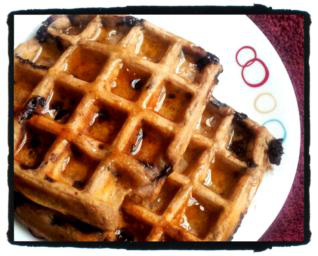

In [16]:
dataset['test'][900]['image']

In [17]:
print(predict(dataset['test'][900]['image']))

waffle


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


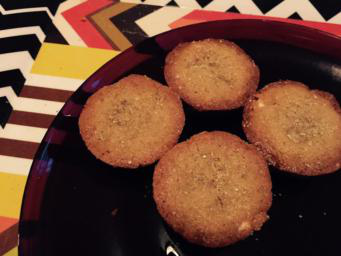

In [18]:
dataset['test'][250]['image']

In [19]:
print(predict(dataset['test'][250]['image']))

cookie
